## Popular Data Science Questions

### Introduction

For this project, we are supposed to be working for a company that creates data science content, be it books, online articles, videos or interactive text-based platforms. Our task is figuring out what is the best content to write about, and there is some leeway in what "best" means here.

Keeping in mind the first objective is helping people to learn, we decide to scour the internet in search for the answer to the question "What is it that people want to learn about in data science?" (as opposed to determining the most profitable content, for instance).

Thinking back to our experience when we first started learning programming, it occurs to us that if we wanted to figure out what programming content to write, we could consult Stack Overflow (a question and answer website about programming) and see what kind of content is more popular.

Therefore, we decide to investigate Stack Overflow a little more and find out that it is part of a question and answer website network called [Stack Exchange](https://stackexchange.com/).

Stack Exchange hosts sites on a multitude of fields and subjects, including mathematics, physics, philosophy, and data science, among others. The website employs a reputation award system for its questions and answers. Each post — each question/answer — is a post that is subject to upvotes and downvotes. This ensures that good posts are easily identifiable.

The fact that [Data Science Stack Exchange (DSSE)](https://datascience.stackexchange.com/) is a data science dedicated site (contrarily to the others), coupled with it having a lot of unanswered questions, makes it an ideal candidate for this investigation. DSSE will be the focus of this guided project. 

This site is a Q&A for Data science professionals, Machine Learning specialists, and those interested in learning more about the field. The site is subdivided into different sections potentially interesting: Questions, Tags (A tag is a keyword or label that categorizes your question with other, similar questions. Using the right tags makes it easier for others to find and answer your question), Users, Unanswered Questions and a Jobs section.

This website is all about getting answers. It's not a discussion forum. There's no chit-chat. Therefore, each post is divided into Answer and Questions. Good answers are voted up and rise to the top.Then, the best answers show up first so that they are always easy to find. The person who asked can mark one answer as "accepted", and accepting doesn't mean it's the best answer, it just means that it worked for the person who asked. 

### First Steps: Data Science Stack Exchange's data model

We decide that the tags will be very useful in categorizing content, saving us the trouble of having to do it by oursleves.

Now comes the challenge of accessing the data _en masse_. One potential solution would be to scrape the site, however, an easier alternative is to use the public database that Stack Exchange provides for each of its websites. [Here](https://data.stackexchange.com/datascience/query/new) is a link to query and explore Data Science Stack Exchange's database. This is called Stack Exchange Data Explorer (SEDE), with its [help section](https://data.stackexchange.com/help) and a [tutorial](https://data.stackexchange.com/tutorial).

SEDE uses SEDE uses Transact-SQL (T-SQL), a Microsoft's proprietary extension to the SQL language that allows to use Microsoft's SQL. By using this syntax, we can access through the interface to the different tables hosted inside SEDE. Some of this tables look useful for our purpose: `Tags`, `Votes`, `TagSynonyms`, `Posts`, etc. 

### Getting the data

One of the interesting tables we can dive into is the `Posts` table. It has a lot of columns, bue we'll be focusing our attention on those that seem relevant towards our goal:


    - Id: An identification number for the post.
    - PostTypeId: An identification number for the type of post.
    
| Id |         Name        |
|:--:|:-------------------:|
|  1 |       Question      |
|  2 |        Answer       |
|  3 |         Wiki        |
|  4 |    TagWikiExcerpt   |
|  5 |       TagWiki       |
|  6 | ModeratorNomination |
|  7 |   WikiPlaceholder   |
|  8 |    PrivilegeWiki    |
   
    - CreationDate: The date and time of creation of the post.
    - Score: The post's score.
    - ViewCount: How many times the post was viewed.
    - Tags: What tags were used.
    - AnswerCount: How many answers the question got (only applicable to question posts).
    - FavoriteCount: How many times the question was favored (only applicable to question posts).

Note that with the exception of the tags column, the last few columns contain information about how popular the post is, the kind of information we're after.

On other hand, there are eight different types of post. Before we try to figure out which of them are relevant to us, let's check how many of them there are through a simple query:

`SELECT PostTypeId, COUNT(*) as NrOfPosts
  FROM posts
 GROUP BY PostTypeId
 ORDER BY NrOfPosts DESC;`

The output for this query is as follows:

| PostTypeId | NrOfPosts |
|:----------:|:---------:|
|      2     |   29547   |
|      1     |   26285   |
|      4     |    246    |
|      5     |    246    |
|      6     |     11    |
|      7     |     1     |

Due to their low volume, anything that isn't questions or answers is mostly inconsequential. Even if it happens to be the case that such kind of posts is immensely popular, they would just be outliers and not relevant to us. We'll then just focus on the questions. Since we're only interested in recent posts, we'll limit our analysis to the posts of 2019. (At the time of writing it is 2020).

The dataset we'll be using in this project is the one resulting that extracts the columns listed above for all the questions in 2019, using the query:

`SELECT Id, PostTypeId, CreationDate, Score, ViewCount, Tags, AnswerCount, FavoriteCount
  FROM Posts
  WHERE CreationDate >= '2019-01-01 00:00:00' AND CreationDate < '2020-01-01 00:00:00';`
  
The result of the query was stored in a file called `2019_questions.csv`.

### Exploring the data

Looking at the of each row, it stands out that `FavoriteCount` has missing values.

In [1]:
# Reading the data

import pandas as pd

questions = pd.read_csv("2019_questions.csv", parse_dates=["CreationDate"])
print(questions.info())
print('Inspecting first rows of the dataframe:', questions.head(5), sep='\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null datetime64[ns]
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    1407 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 483.5+ KB
None
Inspecting first rows of the dataframe:
      Id        CreationDate  Score  ViewCount  \
0  44419 2019-01-23 09:21:13      1         21   
1  44420 2019-01-23 09:34:01      0         25   
2  44423 2019-01-23 09:58:41      2       1651   
3  44427 2019-01-23 10:57:09      0         55   
4  44428 2019-01-23 11:02:15      0         19   

                                                Tags  AnswerCount  \
0                    <machine-learning><data-mining>            0   
1  <machine-learning><regression><linear-regressi...    

As we can see, there's a total of 8839 rows with 7 columns. Only the column `FavoriteCount` has missing values. The types of the columns seems to be ok (integer for the numeric columns, datetime for timestamp column and object -string- for the tags one).

### Cleaning the data

On the other hand, the `Tags` column can be cleaned somehow. We'll want to transform the strings in something more suitable to use typical string methods. Our goal will be to transform them into something like:

"machine-learning,regression,linear-regression,regularization"

We can then split on `,` symbol to obtain a list.

In [2]:
# Filling missing values
questions.fillna(value=0, inplace=True)

# Setting correct types for the columns
questions["FavoriteCount"] = questions["FavoriteCount"].astype(int)

# Cleaning Tags column
questions["Tags"] = questions["Tags"].str.replace("<","").str.replace(">",",").str.replace(r',(?!.)',"")

# Checking changes
print(questions.info())
print('Inspecting first rows of the dataframe:', questions.head(5), sep='\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null datetime64[ns]
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    8839 non-null int64
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 483.5+ KB
None
Inspecting first rows of the dataframe:
      Id        CreationDate  Score  ViewCount  \
0  44419 2019-01-23 09:21:13      1         21   
1  44420 2019-01-23 09:34:01      0         25   
2  44423 2019-01-23 09:58:41      2       1651   
3  44427 2019-01-23 10:57:09      0         55   
4  44428 2019-01-23 11:02:15      0         19   

                                                Tags  AnswerCount  \
0                       machine-learning,data-mining            0   
1  machine-learning,regression,linear-regression,...            0   
2

### Analysis: most popular tags

We now focus on determining the most popular tags. We'll do so by considering two different popularity proxies: for each tag we'll count how many times the tag was used, and how many times a question with that tag was viewed.

We could take into account the score, or whether or not a question is part of someone's favorite questions. These are all reasonable options to investigate; but we'll limit the focus of our research to counts and views for now.

In [3]:
# Counting how many times each tag was used
tags = questions["Tags"].str.split(pat=",")
tags_dict = {}

def count_tags(list_):
    for value in list_:
        if value not in tags_dict:
            tags_dict[value] = 1
        else:
            tags_dict[value] += 1
    return None

tags.apply(count_tags)
tag_count = pd.DataFrame.from_dict(tags_dict, orient='index')
tag_count.rename(columns={0: "Count"}, inplace=True)
tag_count.sort_values(by=['Count'], ascending=False, inplace=True)
print('Top 10 used tags:', tag_count.head(10), sep='\n')

Top 10 used tags:
                  Count
machine-learning   2693
python             1814
deep-learning      1220
neural-network     1055
keras               935
classification      685
tensorflow          584
scikit-learn        540
nlp                 493
cnn                 489


In [4]:
# Counting how many times each tag was viewed
tags_views = pd.DataFrame(tags)
tags_views["views"] = questions["ViewCount"]

views_dict = {}

def count_tag_views(row):
    tags_list = row["Tags"]
    views = row["views"]
    for value in tags_list:
        if value not in views_dict:
            views_dict[value] = views
        else:
            views_dict[value] += views
    return None

tags_views.apply(count_tag_views, axis="columns")
views_count = pd.DataFrame.from_dict(views_dict, orient='index')
views_count.rename(columns={0: "Count"}, inplace=True)
views_count.sort_values(by=['Count'], ascending=False, inplace=True)
print('Top 10 viewed tags:', views_count.head(10), sep='\n')

Top 10 viewed tags:
                   Count
python            537585
machine-learning  388499
keras             268608
deep-learning     233628
pandas            201787
neural-network    185367
scikit-learn      128110
tensorflow        121369
classification    104457
dataframe          89352


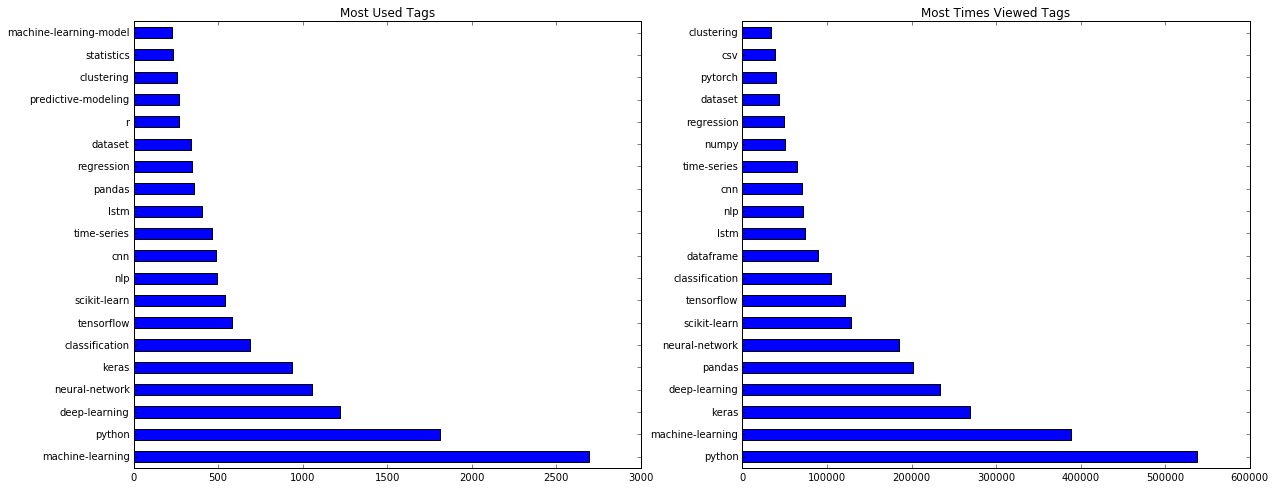

In [5]:
#del tags
#del tags_views
import matplotlib.pyplot as plt
%matplotlib inline

# Visualizing results
fig_1 = plt.figure(figsize=(20,8))
ax1 = fig_1.add_subplot(1, 2, 1)
ax2 = fig_1.add_subplot(1, 2, 2)
tag_count.head(20).plot(kind='barh', ax=ax1, legend=False, title='Most Used Tags')
views_count.head(20).plot(kind='barh', ax=ax2, legend=False, title='Most Times Viewed Tags')

### Extra Analysis: interest in deep learning across time

Once obtained the most popular tags in Data Science questions, we can proceed to analyze individually each one of the tags processed. We are going to make a shallow analysis of the deep learning tag in order to exemplify this analysis and, while we are on it, answer to the question: _Is deep learning just a fad?_.

For this part, we will answer the following questions:

   - Count how many deep learning questions are asked per time period.
   - The total amount of questions per time period.
   - How many deep learning questions there are relative to the total amount of questions per time period.

To obtain the data, we can query SEDE with the following code:

`SELECT Id, CreationDate, Tags
  FROM posts
 WHERE PostTypeId = 1;`
 
The file `all_questions.csv` holds the result of the query above.

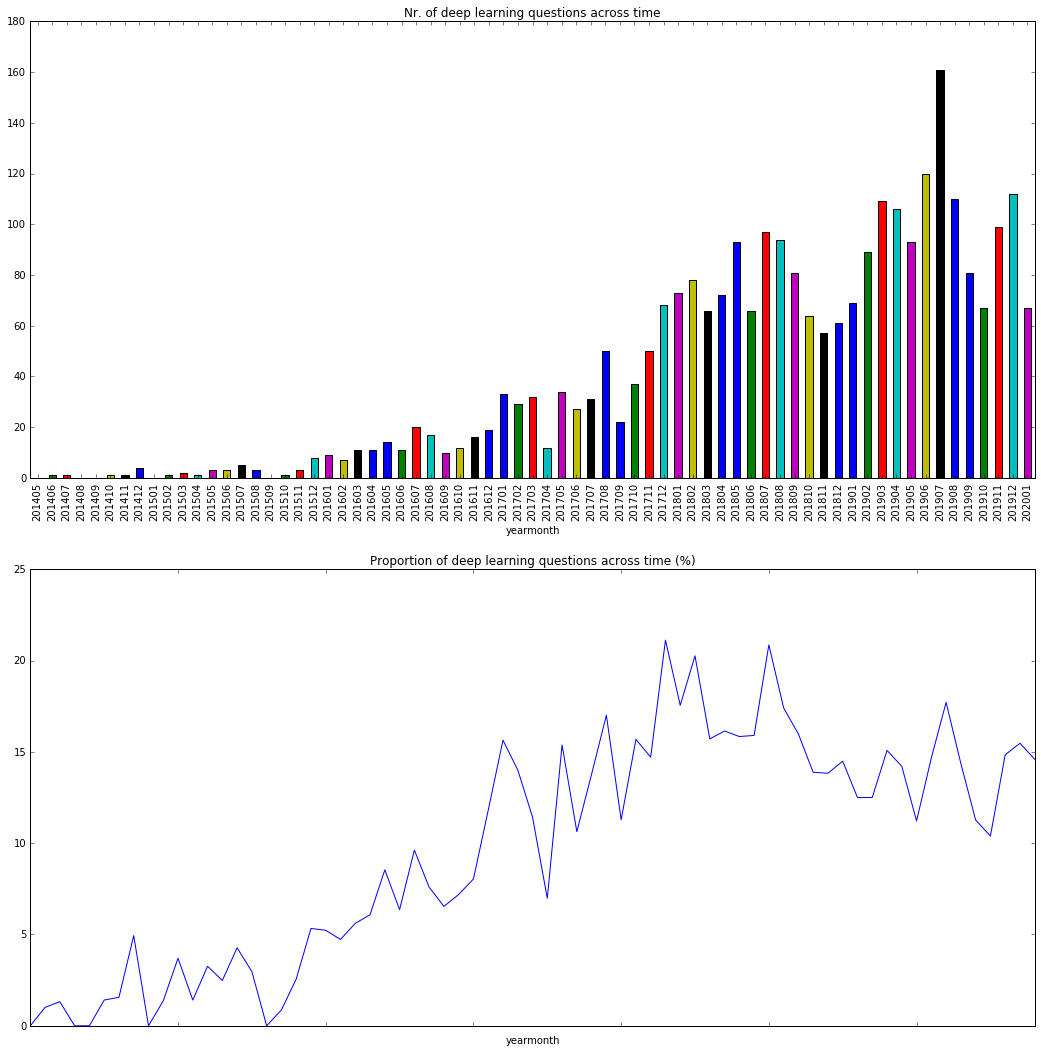

In [6]:
import datetime as dt

# Reading dataset
all_questions = pd.read_csv("all_questions.csv", parse_dates=["CreationDate"])

# Cleaning dataset
all_questions["Tags"] = all_questions["Tags"].str.replace("<","").str.replace(">",",").str.replace(r',(?!.)',"")

# Processing deep learning questions only
dl_questions = all_questions[all_questions.Tags.str.contains('deep-learning')].copy()

# Mananing deep learning dataset
dl_questions["yearmonth"] = dl_questions["CreationDate"].dt.year.astype(str) + dl_questions["CreationDate"].dt.month.astype(str).str.zfill(2)
dl_grouped_series = dl_questions.groupby("yearmonth").agg('size')
dl_df = pd.DataFrame(dl_grouped_series, columns=["nr_dl_questions"])

# Mananing all questions dataset
all_questions["yearmonth"] = all_questions["CreationDate"].dt.year.astype(str) + all_questions["CreationDate"].dt.month.astype(str).str.zfill(2)
all_questions_series = all_questions.groupby("yearmonth").agg('size')
aq_df = pd.DataFrame(all_questions_series, columns=["nr_all_questions"])

# Merging both datasets
merged_questions = pd.merge(left=aq_df, right=dl_df, how='left', left_index=True, right_index=True)
merged_questions.fillna(0, inplace=True)
merged_questions["proportion_dl_questions"] = round((merged_questions["nr_dl_questions"] / merged_questions["nr_all_questions"]) * 100, 2)
merged_questions.reset_index(inplace=True)

# Visualizing results
fig_2 = plt.figure(figsize=(18,18))
ax3 = fig_2.add_subplot(2, 1, 1)
ax4 = fig_2.add_subplot(2, 1, 2)
merged_questions.plot(x='yearmonth', y='nr_dl_questions', kind='bar', ax=ax3, legend=False, title='Nr. of deep learning questions across time')
merged_questions.plot.line(x='yearmonth', y='proportion_dl_questions', ax=ax4, legend=False, title='Proportion of deep learning questions across time (%)')

As per the results, we can see that deep learning questions are quite popular among all data science tags, and its interest has increased these last years, maintaining a regular percentage proportion from the total data science's questions (between 10-20%).